## Carlifornia House Price ML Modelling

- We have been given a data set for the Carlifornia state
- We are required to predict the median housing price in a block/district given some features
- We start by importing the required packages and data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import linear_model
from sklearn.datasets import fetch_california_housing

- The problem as it is framed requires supervised learning 
- We employ regression techniques.
- Thus the performance measure is:

$$
 RMSE = \sqrt{\frac{1}{n}\sum (y_i - \hat{y}_i)^2}
$$
where $\hat{y}_i = h(X_i)$ is the approximate $y_i$ value for some vector input $X_i$, and $h$ is the prediction function.
- RMSE is refered to as the $\mathcal{l}_2$-norm and can be affected by outliers.
- When there are outliers in the data the $\mathcal{l}_1$-norm MAE is prefered:
$$
 MAE = {\frac{1}{n}\sum |y_i - \hat{y}_i|}.
$$
- Note that the $\mathcal{l}_k$-norm is defined as: 
$$
(\sum |w_i|^k)^{1/k}.
$$
The higher the $k$ the more prone it is to outliers.

In [2]:
'''df = fetch_california_housing()
print(df.data.shape)
df.data'''

data = pd.read_csv("datasets/housing/housing.csv")
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Exploratory Data Analysis & Train Test Splitting
- We have acquired the data and are ready to inspect it.
- We use the 'head' method and then summarise the data
- Additionally, use describe function to get summary statistics

In [39]:
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [40]:
# Ocean Proximity is a categorical variable
data['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

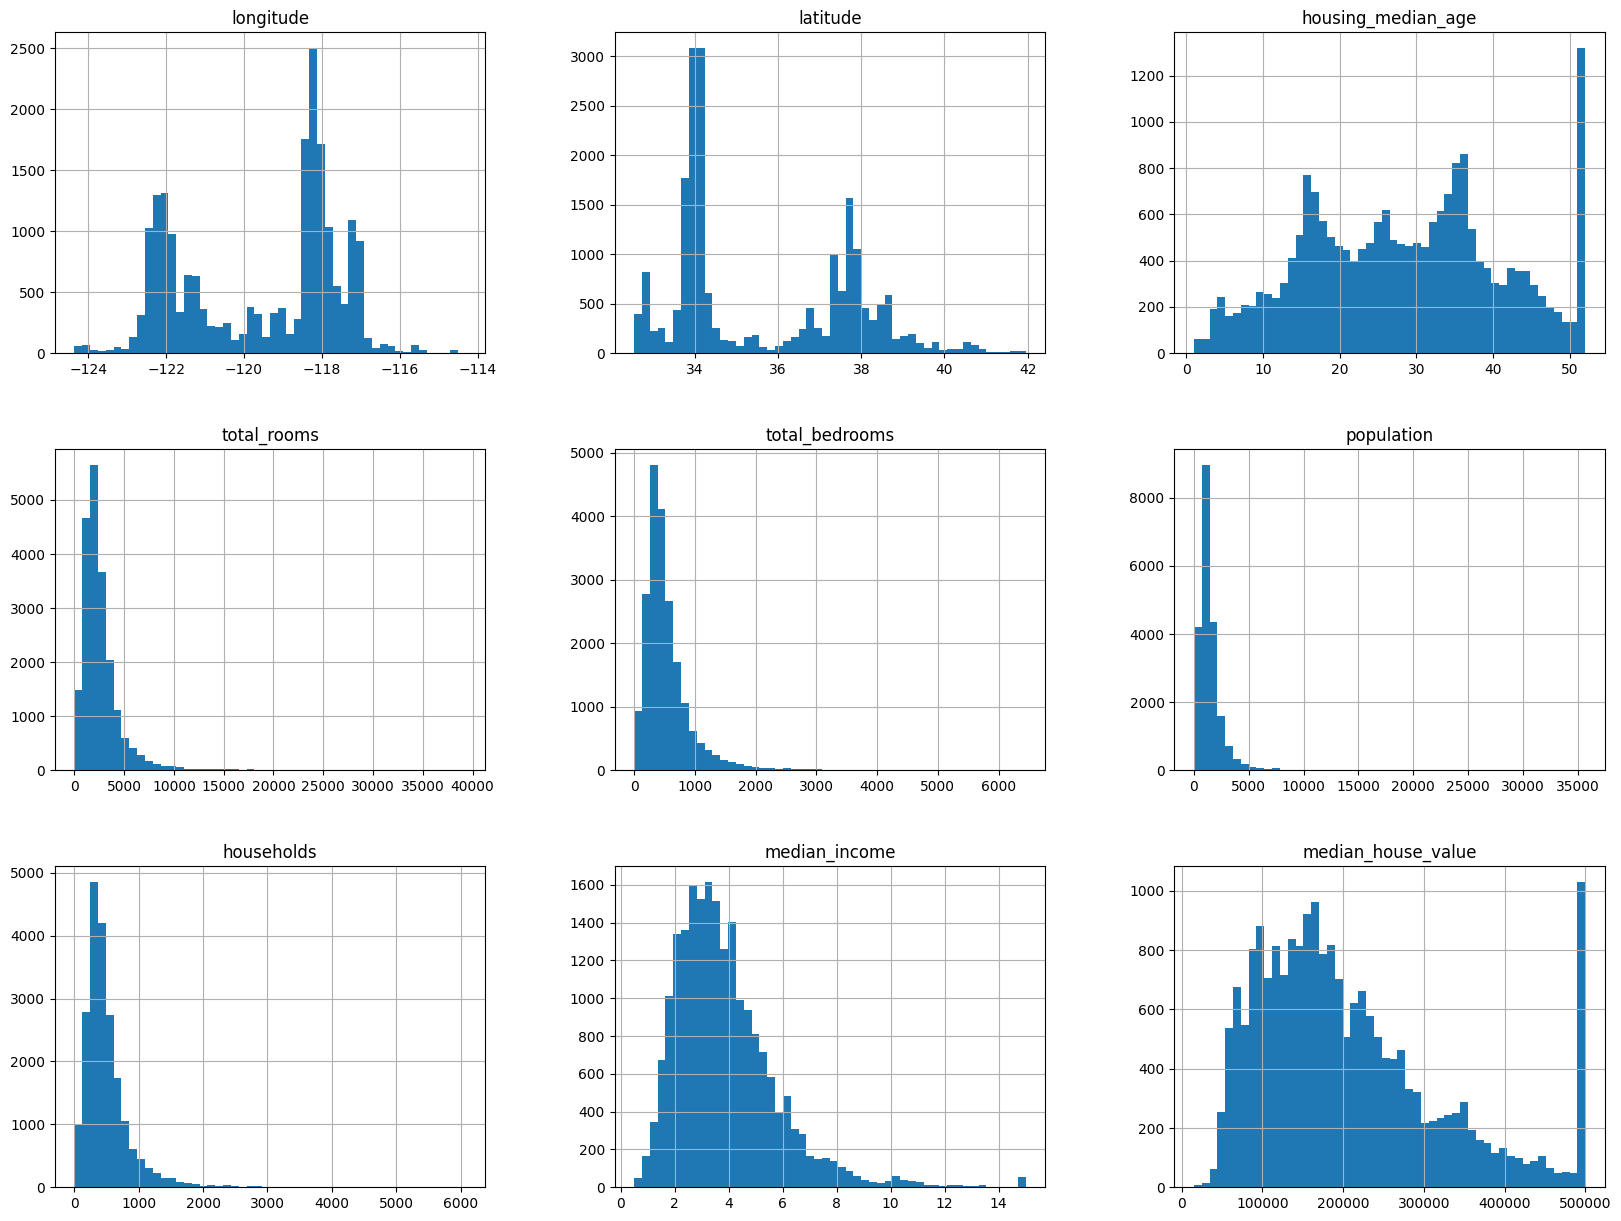

In [7]:
data.hist(bins=50, figsize=(20,15));

In [10]:
correlation = data[['housing_median_age', 'total_rooms',
                    'total_bedrooms', 'population', 'median_income',
                    'median_house_value']].corr()
correlation.style.background_gradient()

,housing_median_age,total_rooms,total_bedrooms,population,median_income,median_house_value
housing_median_age,1.000000,-0.361262,-0.320451,-0.296244,-0.119034,0.105623
total_rooms,-0.361262,1.000000,0.930380,0.857126,0.198050,0.134153
total_bedrooms,-0.320451,0.930380,1.000000,0.877747,-0.007723,0.049686
population,-0.296244,0.857126,0.877747,1.000000,0.004834,-0.024650
median_income,-0.119034,0.198050,-0.007723,0.004834,1.000000,0.688075
median_house_value,0.105623,0.134153,0.049686,-0.024650,0.688075,1.000000


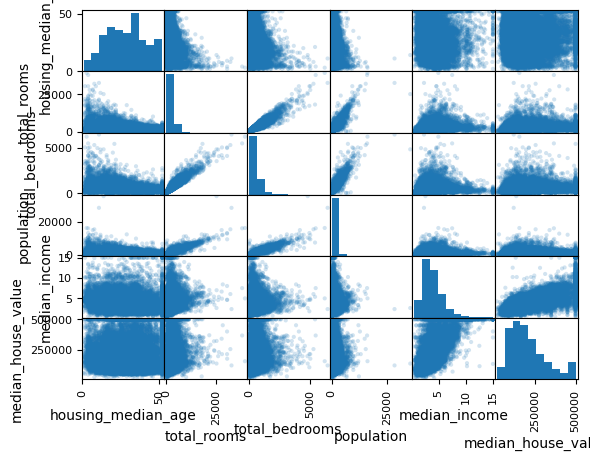

In [14]:
pd.plotting.scatter_matrix(data[['housing_median_age', 'total_rooms',
                    'total_bedrooms', 'population', 'median_income',
                    'median_house_value']],
                    alpha=0.2);

### Train-Test-Validation Splits (1)

- We train the model om 70% of the data and test in on 15% of the data
- The rest is for validation
- In this section we use random sampling to create our splits

In [15]:
import random

trianProp = 0.70
testProp  = 0.15

def trainTestSplit(data, trainProp,testProp=0):
    numData = len(data)
    trainNum = int(trainProp * numData)
    trainIndices = random.sample(list(np.arange(0,numData)),
                          trainNum)
    remaining = set(np.arange(0,numData)).symmetric_difference(set(trainIndices))
    trainData = data.iloc[trainIndices]
    validationData = None
    if ((trainProp+testProp)<1):
        # Check if a validation test is required
        testNum = int(testProp * numData)
        testIndices = random.sample(list(remaining),testNum)
        testData = data.iloc[testIndices]
        remaining = remaining.symmetric_difference(testIndices) 
        validationData = data.iloc[list(remaining)]
    else:        
        testData = data.iloc[list(remaining)]
    return trainData, testData, validationData

In [16]:
train, test, validation = trainTestSplit(data,0.7,0.15)
print(data.shape)
print(train.shape)
print(test.shape)
print(validation.shape)

(20640, 11)
(14447, 11)
(3096, 11)
(3097, 11)


In [17]:
# Sciki Learn has an inbuilt data splitting function
from sklearn.model_selection import train_test_split

trainSet, testSet = train_test_split(data,test_size=0.3, random_state=42)

### Train Test Splits (2)
- Since the income group is important to the data, we want the splits to reflect this distribution well.
- So we create a train-test split that observes these proportions
- the median income may be a significant factor.
- Lets create a categorical variable

<Axes: >

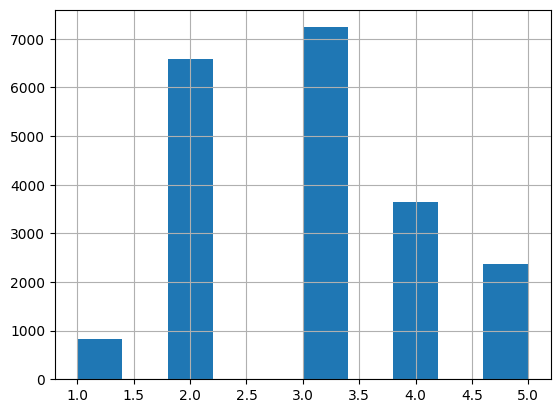

In [45]:
data['income_cat'] = pd.cut(data['median_income'],
                            bins = [0., 1.5, 3, 4.5, 6., np.inf],
                            labels = [1, 2, 3, 4, 5])
data['income_cat'].hist()

In [46]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1,test_size=0.3, random_state=42)
for train_index, test_index in split.split(data,data['income_cat']):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]

strat_test_set['income_cat'].value_counts()/len(strat_test_set)

income_cat
3    0.350614
2    0.318798
4    0.176357
5    0.114341
1    0.039890
Name: count, dtype: float64

- We can drop the "Income Category" column

In [47]:
for df in (strat_test_set, strat_train_set):
    df.drop("income_cat", 
            axis=1, inplace=True)

#### Data Exploration
- Lets run an exploratory data analysis only on the *training data*

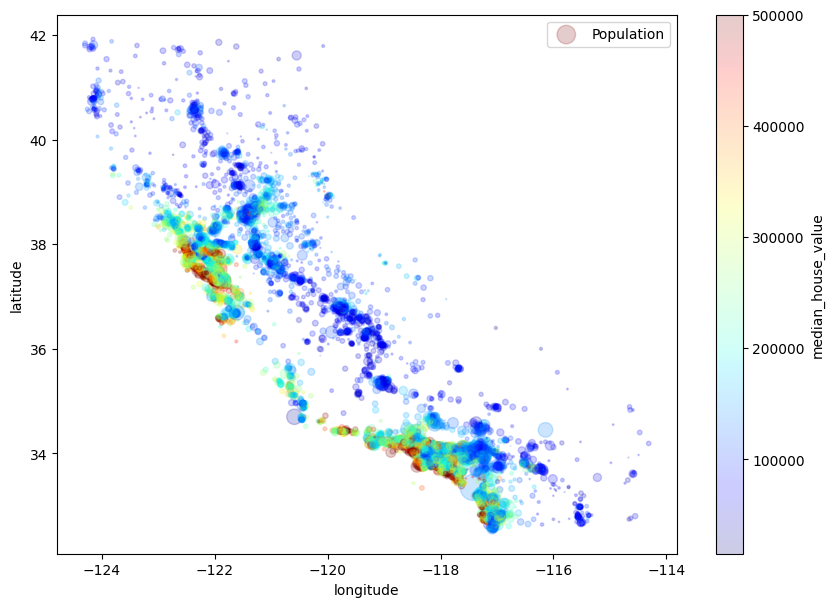

In [30]:
strat_train_set.plot(kind='scatter', x='longitude', y='latitude',
                     alpha=0.2, # point transparency
                     s = strat_train_set['population']/100, # change point size based on population
                     label = 'Population', figsize=(10,7),
                     c='median_house_value', # to control point colour
                     cmap=plt.get_cmap('jet'), colorbar=True
                     )
plt.legend()

### Making the data make sense
- The following columns do not make sense on their own: 
    - 'total_rooms',
    - 'total_bedrooms'


In [39]:
trainData = strat_train_set.copy()

In [33]:
correlation = trainData[['housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value']].corr()
correlation.style.background_gradient()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
housing_median_age,1.000000,-0.362810,-0.322190,-0.296377,-0.302394,-0.112490,0.116305
total_rooms,-0.362810,1.000000,0.929288,0.853244,0.917442,0.200391,0.136801
total_bedrooms,-0.322190,0.929288,1.000000,0.873909,0.979684,-0.009279,0.049523
population,-0.296377,0.853244,0.873909,1.000000,0.902632,0.002690,-0.024592
households,-0.302394,0.917442,0.979684,0.902632,1.000000,0.011088,0.066788
median_income,-0.112490,0.200391,-0.009279,0.002690,0.011088,1.000000,0.687873
median_house_value,0.116305,0.136801,0.049523,-0.024592,0.066788,0.687873,1.000000


- We will create new variables:
    - rooms per household
    - bedrooms per room, and
    - population per house hold

In [37]:
trainData['rooms_per_household'] =      trainData['total_rooms']/trainData['households']
trainData['bedrooms_per_room'] =        trainData['total_bedrooms']/trainData['total_rooms']
trainData['population_per_household'] = trainData['population']/trainData['households']

In [38]:
correlation = trainData[['housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'rooms_per_household','bedrooms_per_room','population_per_household']].corr()
correlation.style.background_gradient()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
housing_median_age,1.000000,-0.362810,-0.322190,-0.296377,-0.302394,-0.112490,0.116305,-0.160069,0.131391,0.011985
total_rooms,-0.362810,1.000000,0.929288,0.853244,0.917442,0.200391,0.136801,0.137899,-0.189700,-0.021771
total_bedrooms,-0.322190,0.929288,1.000000,0.873909,0.979684,-0.009279,0.049523,0.003806,0.093344,-0.025219
population,-0.296377,0.853244,0.873909,1.000000,0.902632,0.002690,-0.024592,-0.079330,0.042720,0.068872
households,-0.302394,0.917442,0.979684,0.902632,1.000000,0.011088,0.066788,-0.088024,0.073499,-0.024032
median_income,-0.112490,0.200391,-0.009279,0.002690,0.011088,1.000000,0.687873,0.329378,-0.629917,0.024150
median_house_value,0.116305,0.136801,0.049523,-0.024592,0.066788,0.687873,1.000000,0.144427,-0.262723,-0.024005
rooms_per_household,-0.160069,0.137899,0.003806,-0.079330,-0.088024,0.329378,0.144427,1.000000,-0.420560,-0.010955
bedrooms_per_room,0.131391,-0.189700,0.093344,0.042720,0.073499,-0.629917,-0.262723,-0.420560,1.000000,0.008822
population_per_household,0.011985,-0.021771,-0.025219,0.068872,-0.024032,0.024150,-0.024005,-0.010955,0.008822,1.000000


### Data Cleaning

In [48]:
# Seperate input and output values
housingLabels = strat_train_set['median_house_value'].copy()
housingFeatures = strat_train_set.drop('median_house_value', axis =1)

In [49]:
# Replace missing values in the training set:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = "median")

# Create a copy of the data without the categorical column
housingNum = housingFeatures.drop('ocean_proximity', axis=1)
imputer.fit(housingNum)
print(imputer.statistics_)
print(housingNum.median().values)

[-118.51    34.26    29.    2111.     430.    1159.     406.       3.536]
[-118.51    34.26    29.    2111.     430.    1159.     406.       3.536]


In [44]:
housingNum.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14448 entries, 8577 to 7730
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           14448 non-null  float64 
 1   latitude            14448 non-null  float64 
 2   housing_median_age  14448 non-null  float64 
 3   total_rooms         14448 non-null  float64 
 4   total_bedrooms      14308 non-null  float64 
 5   population          14448 non-null  float64 
 6   households          14448 non-null  float64 
 7   median_income       14448 non-null  float64 
 8   income_cat          14448 non-null  category
dtypes: category(1), float64(8)
memory usage: 1.0 MB


## SK-learn linear model

- Clearly, there ois a linear relationship between living area and house prices

In [13]:
X = np.c_[df['Living.Area']]
y = np.c_[df['Price']]

#Select a model
model = linear_model.LinearRegression()

# Train the model
model.fit(X,y)

LinearRegression()

In [15]:
# Apply the model to new data points:

X_new = [[2250]]
print(model.predict(X_new))

[[205915.43723176]]
